In [6]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [7]:
data_dir = Path("../../data/processed")  
files = {
    "DF": data_dir / "players_data_DF_normalized.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_df = load_clean(files["DF"])




# Cluster Defenders

In [8]:
print("DF shape:", df_df.shape)
df_df.head()
df_df.info()
df_df.describe()
df_df.select_dtypes(include="object").columns

# drop_cols = ["__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
categorical_cols = ['Rk','Player', 'Nation', 'Pos','Squad', 'Comp', 'Age','Born','MP','Starts','Min','90s',
                    'numeric_wage', 'foot', 'W', 'D', 'L']
df_features = df_df.drop(columns=categorical_cols, errors="ignore")



# Print the shape and preview of the numeric dataset
print("Numeric dataset shape:", df_features.shape)
df_features.head()

df_scaled = df_features  # Data is already normalized

# Apply PCA to reduce dimensions to 2D for plotting and visualization
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, algorithm='elkan')
df_clusters = kmeans.fit_predict(df_pca)

# Add cluster labels to the original dataframe for easy reference
df_df["cluster"] = df_clusters


DF shape: (640, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 121 entries, Rk to exposure_score
dtypes: float64(111), int64(4), object(6)
memory usage: 605.1+ KB
Numeric dataset shape: (640, 107)


### Plot and List

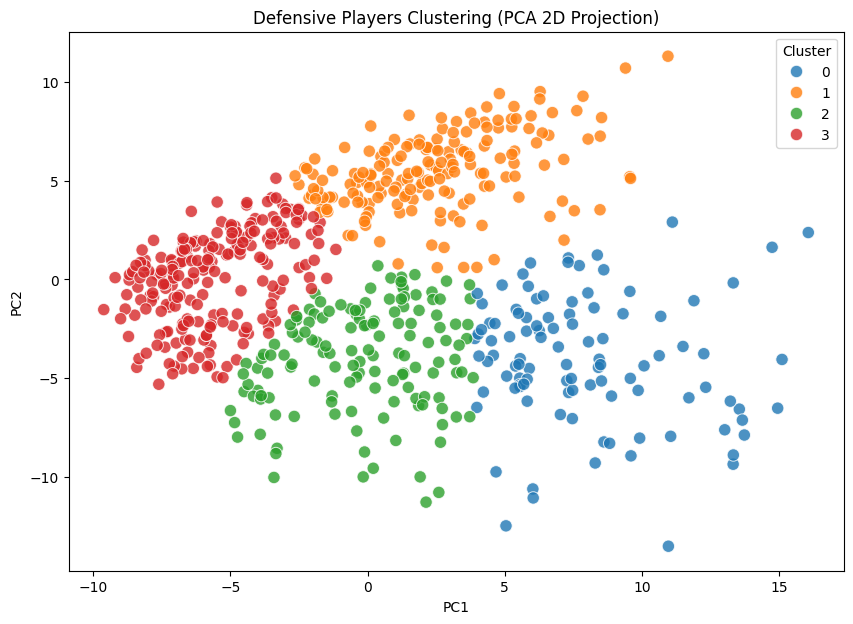

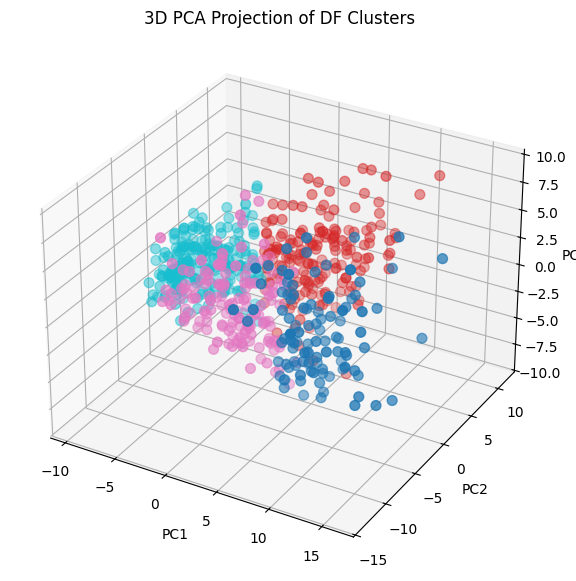

Eigenvalues (variance explained by each PC): [28.85028538 20.51333414  9.16002194]
Explained variance ratio: [0.28162314 0.20024168 0.0894159 ]
Cumulative variance explained: [0.28162314 0.48186482 0.57128072]


In [9]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=df_pca[:,0], 
    y=df_pca[:,1], 
    hue=df_df["cluster"],       
    palette="tab10", 
    s=80,
    alpha=0.8
)



plt.title("Defensive Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()



# Fit PCA for 3 components
pca_3d = PCA(n_components=3, random_state=42)
df_pca_3d = pca_3d.fit_transform(df_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_pca_3d[:,0], df_pca_3d[:,1], df_pca_3d[:,2], 
    c=df_df["cluster"], cmap="tab10", s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of DF Clusters")
plt.show()

# Print eigenvalues / explained variance
print("Eigenvalues (variance explained by each PC):", pca_3d.explained_variance_)
print("Explained variance ratio:", pca_3d.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca_3d.explained_variance_ratio_))


# Evaluate Defenders

In [10]:

sil_score = silhouette_score(df_scaled, df_df["cluster"])
print("Silhouette Score:", sil_score)


dbi = davies_bouldin_score(df_scaled, df_df["cluster"])
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(df_scaled, df_df["cluster"])
print("Calinski-Harabasz Score:", ch_score)

# After fitting PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=df_features.columns
)

# Sort features by importance for PC1 and PC2
loadings_PC1 = loadings["PC1"].abs().sort_values(ascending=False)
loadings_PC2 = loadings["PC2"].abs().sort_values(ascending=False)

print("Top PC1 drivers:\n", loadings_PC1.head(15))
print("\nTop PC2 drivers:\n", loadings_PC2.head(15))

low_variance = df_features.var().sort_values().head(50)
print(low_variance)

Silhouette Score: 0.14913045037949155
Davies-Bouldin Index: 2.004973411755127
Calinski-Harabasz Score: 123.36988689201254
Top PC1 drivers:
 Recov                       0.159032
Touches                     0.158378
Live_stats_possession       0.158376
Min%                        0.156917
exposure_score              0.156064
onxG                        0.153187
Att                         0.152123
PrgP                        0.150368
PassLive                    0.148929
SCA                         0.144542
onG                         0.144492
Rec                         0.140310
Carries                     0.140124
Mid 3rd_stats_possession    0.140027
TotDist_stats_possession    0.138449
Name: PC1, dtype: float64

Top PC2 drivers:
 Def 3rd_stats_possession    0.188285
Def Pen                     0.187983
SCA90                       0.167304
PrgR                        0.164129
Clr                         0.163563
Sh_stats_defense            0.159722
Won                         0.156976
x

# Clustering Defenders with PC1 and PC2 Feature Selection

,Selected Features
0,Rec
1,exposure_score
2,SCA
3,PrgDist
4,PrgP
5,1/3_stats_possession
6,Touches
7,xG+xAG
8,Clr
9,onG


K=4: Silhouette Score = 0.2656
Davies-Bouldin Index: 1.2904121521231207
Calinski-Harabasz Score: 305.18432309607186


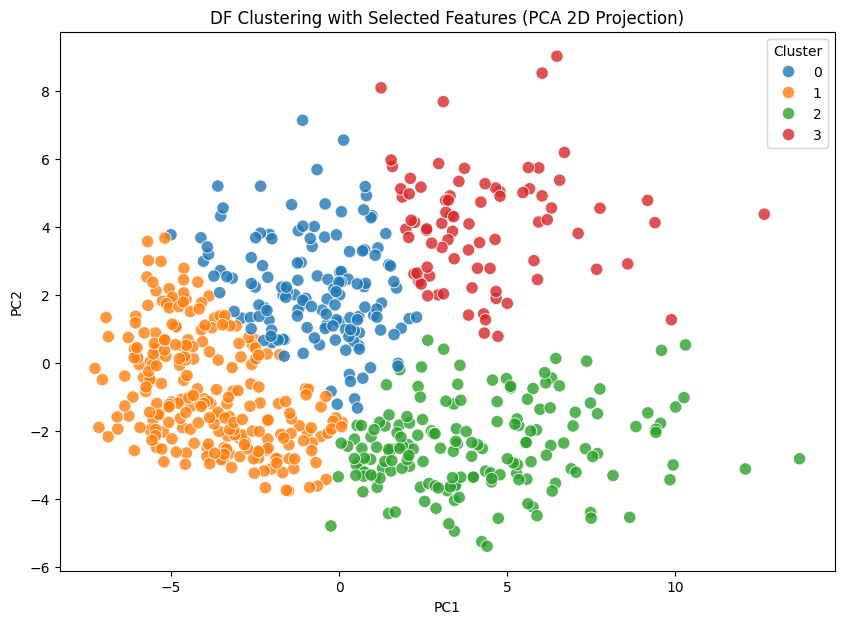

Players in cluster 0: 142


,Player,Squad,Pos,cluster
1,Ali Abdi,Nice,"DF,MF",0
2,Abel,Osasuna,DF,0
9,Felix Agu,Werder Bremen,DF,0
16,Sergio Akieme,Reims,DF,0
24,Hugo Álvarez,Celta Vigo,"MF,DF",0
...,...,...,...,...
619,Neco Williams,Nott'ham Forest,DF,0
621,Marius Wolf,Augsburg,DF,0
625,Ashley Young,Everton,DF,0
632,Davide Zappacosta,Atalanta,DF,0


Players in cluster 1: 247


,Player,Squad,Pos,cluster
0,Yunis Abdelhamid,Saint-Étienne,DF,1
3,Abner,Lyon,DF,1
4,Abdel Abqar,Alavés,DF,1
5,Francesco Acerbi,Inter,DF,1
6,Tosin Adarabioyo,Chelsea,DF,1
...,...,...,...,...
633,David Zec,Holstein Kiel,DF,1
634,Jordan Zemura,Udinese,DF,1
635,Alessio Zerbin,Venezia,DF,1
636,Cedric Zesiger,Augsburg,DF,1


Players in cluster 2: 170


,Player,Squad,Pos,cluster
10,Nayef Aguerd,Real Sociedad,DF,2
17,Clément Akpa,Auxerre,DF,2
18,Kevin Akpoguma,Hoffenheim,DF,2
20,Omar Alderete,Getafe,DF,2
22,Marcos Alonso,Celta Vigo,DF,2
...,...,...,...,...
610,Stefan de Vrij,Inter,DF,2
611,Hauke Wahl,St. Pauli,DF,2
626,Etienne Youte Kinkoue,Le Havre,DF,2
627,Illia Zabarnyi,Bournemouth,DF,2


Players in cluster 3: 81


,Player,Squad,Pos,cluster
12,Ola Aina,Nott'ham Forest,DF,3
13,Rayan Aït-Nouri,Wolves,DF,3
15,Manuel Akanji,Manchester City,DF,3
21,Trent Alexander-Arnold,Liverpool,DF,3
27,Michael Amir Murillo,Marseille,DF,3
...,...,...,...,...
614,Aaron Wan-Bissaka,West Ham,DF,3
616,Mitchell Weiser,Werder Bremen,"DF,MF",3
620,Maximilian Wittek,Bochum,DF,3
628,Warren Zaïre-Emery,Paris S-G,"MF,DF",3


In [11]:
# Drop features with low variance and select top features from PC1 and PC2
selected_features = list(loadings_PC1.head(20).index) + list(loadings_PC2.head(10).index)
selected_features = list(set(selected_features))  # Remove duplicates
selected_features_df = pd.DataFrame(selected_features, columns=["Selected Features"])
display(selected_features_df)



df_scaled_sel = df_df[selected_features].copy()
# Make Nan values 0
# fw_sel = fw_sel.fillna(0)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# fw_scaled_sel = scaler.fit_transform(fw_sel)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(df_scaled_sel)
sil = silhouette_score(df_scaled_sel, clusters)
print(f"K=4: Silhouette Score = {sil:.4f}")

# Evaluate
dbi = davies_bouldin_score(df_scaled_sel, clusters)
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(df_scaled_sel, clusters)
print("Calinski-Harabasz Score:", ch_score)

# Add cluster labels to the original dataframe for easy reference
df_df["cluster"] = clusters

# Plotting with selected features
pca_sel = PCA(n_components=2, random_state=42)
df_pca_sel = pca_sel.fit_transform(df_scaled_sel)
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=df_pca_sel[:,0], 
    y=df_pca_sel[:,1], 
    hue=clusters,       
    palette="tab10", 
    s=80,
    alpha=0.8
)
plt.title("DF Clustering with Selected Features (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# List players from cluster 1

cluster_0_players = df_df[df_df["cluster"] == 0][["Player", "Squad", "Pos", "cluster"]]
cluster_1_players = df_df[df_df["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
cluster_2_players = df_df[df_df["cluster"] == 2][["Player", "Squad", "Pos", "cluster"]]
cluster_3_players = df_df[df_df["cluster"] == 3][["Player", "Squad", "Pos", "cluster"]]

print(f"Players in cluster 0: {len(cluster_0_players)}")
display(cluster_0_players)
print(f"Players in cluster 1: {len(cluster_1_players)}")
display(cluster_1_players)
print(f"Players in cluster 2: {len(cluster_2_players)}")
display(cluster_2_players)
print(f"Players in cluster 3: {len(cluster_3_players)}")
display(cluster_3_players)







In [12]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

feature_cols = selected_features
X = df_scaled_sel.values
labels = clusters

per_cluster_nn = {}
per_cluster_idx = {}

for c in np.unique(labels):
    indx = np.where(labels == c)[0]
    Xc = X[indx, :]
    # n_neighbors+1 to allow excluding self at query time
    nn = NearestNeighbors(n_neighbors=min(11, len(indx)), metric="euclidean", algorithm="auto")
    nn.fit(Xc)
    per_cluster_nn[c] = nn
    per_cluster_idx[c] = indx

def nearest_players_within_cluster(df, player_name=None, row_idx=None, k=5, id_col="Player"):
    if player_name is None and row_idx is None:
        raise ValueError("Provide either player_name or row_idx.")
    if row_idx is None:
        match = df.index[df[id_col] == player_name].tolist()
        if not match:
            raise ValueError(f"Player '{player_name}' not found in column '{id_col}'.")
        row_idx = match[0]

    c = labels[row_idx]
    nn = per_cluster_nn[c]
    idx = per_cluster_idx[c]

    xq = X[row_idx].reshape(1, -1)
    n_q = min(k+1, len(idx))
    dists, inds = nn.kneighbors(xq, n_neighbors=n_q)
    dists, inds = dists[0], inds[0]

    global_inds = idx[inds]
    mask = global_inds != row_idx
    global_inds = global_inds[mask]
    dists = dists[mask]
    global_inds = global_inds[:k]
    dists = dists[:k]

    cols_to_show = [c for c in [id_col, "Rk", "Pos", "Squad", "cluster"] if c in df.columns]
    out = df.iloc[global_inds][cols_to_show].copy()
    out["distance"] = dists
    return out.reset_index(drop=True)

# Example usage:
display(nearest_players_within_cluster(df_df, player_name="Virgil van Dijk", k=10))


,Player,Rk,Pos,Squad,cluster,distance
0,Amir Rrahmani,2269,DF,Napoli,2,4.051667
1,Levi Colwill,584,DF,Chelsea,2,4.951247
2,Pau Cubarsí,634,DF,Barcelona,2,5.628435
3,Obite N'Dicka,1845,DF,Roma,2,5.885462
4,Jonathan Tah,2545,DF,Leverkusen,2,5.900843
5,Kim Min-jae,1750,DF,Bayern Munich,2,6.190304
6,William Saliba,2311,DF,Arsenal,2,6.196418
7,Alexsandro Ribeiro,2206,DF,Lille,2,6.224499
8,Jan Paul van Hecke,1137,DF,Brighton,2,6.474467
9,Leonardo Balerdi,219,DF,Marseille,2,7.206142
